### 1.1 Import Libraries

In [1]:
%matplotlib inline

import os
import cv2
import math
import time
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# OpenCV's implementation of Haar Cascade Classifier
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')

OpenCV provides many pre-trained object detectors, including full human body detectors, license plate detectors, and more.  They are stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  Some of them have been downloaded in the `detector_architectures` folder.

### 1.2 Read All Images

In [3]:
image_family = cv2.cvtColor(cv2.imread('images/test_image_1.jpg'), cv2.COLOR_BGR2RGB)
image_james = cv2.cvtColor(cv2.imread('images/james.jpg'), cv2.COLOR_BGR2RGB)
image_obama = cv2.cvtColor(cv2.imread('images/obamas4.jpg'), cv2.COLOR_BGR2RGB)
image_fawzia = cv2.cvtColor(cv2.imread('images/fawzia.jpg'), cv2.COLOR_BGR2RGB)
image_gus = cv2.cvtColor(cv2.imread('images/gus.jpg'), cv2.COLOR_BGR2RGB)

In [4]:
# option cv2.IMREAD_UNCHANGED is used because the sunglasses image has a 4th channel about transparency
sunglasses = cv2.imread("images/sunglasses_4.png", cv2.IMREAD_UNCHANGED)
print ('The sunglasses image has shape: ' + str(np.shape(sunglasses)))

The sunglasses image has shape: (1123, 3064, 4)


By default OpenCV assumes the ordering of our image's color channels are Blue, then Green, then Red.  We will use OpenCV's ```cvtColor``` function, which is a general utility function that can do other transformations too like converting a color image to grayscale, and transforming a standard color image to HSV color space. [More documentation](http://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html)

### 1.3 Utility Functions

In [5]:
def load_data(test=False):
    """
    Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Important that the files are in a `data` directory
    """  
    FTRAIN = 'data/training.csv'
    FTEST = 'data/test.csv'
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))

    # The Image column has pixel values separated by space
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    # For simplicity, remove those images with missing labels
    df = df.dropna()
    # scale pixel values to [0, 1]
    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)
    X = X.reshape(-1, 96, 96, 1)
    
    # only FTRAIN has target columns
    if not test: 
        y = df[df.columns[:-1]].values
        # scale target coordinates to [-1, 1]
        y = (y - 48) / 48
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [6]:
def plot_data(img, landmarks, axis):
    axis.imshow(np.squeeze(img), cmap='gray')
    # undo the normalization
    landmarks = landmarks * 48 + 48
    axis.scatter(landmarks[0::2], landmarks[1::2], marker='o', c='c', s=40)

In [7]:
def plot_two_image(imageA, imageB, titleA='Image A', titleB='Image B', grayB=False, size=(16,16)): 
    fig = plt.figure(figsize=size)
    ax1 = fig.add_subplot(121)
    ax1.set_title(titleA)
    ax1.imshow(imageA)
    ax2 = fig.add_subplot(122)
    ax2.set_title(titleB)
    if grayB: ax2.imshow(imageB, cmap='gray')
    else: ax2.imshow(imageB)

In [8]:
def blur_image(image, width=4): 
    avg_kernel = np.ones((width, width), np.float32) / (width * width)
    avg_image = cv2.filter2D(image, -1, avg_kernel)
    return avg_image

Blur an image by using OpenCV's ```filter2d``` functionality - which is discussed in [this documentation page](http://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html)

In [9]:
def noisy_image(image, noise=40): 
    image_noisy = np.asarray(image)
    # common noise model - Gaussian distribution
    image_noise = np.random.randn(image.shape[0], image.shape[1], image.shape[2]) * noise
    image_noisy = image_noisy + image_noise
    # Convert back to uint8 format
    image_noisy = np.asarray([np.uint8(np.clip(i,0,255)) for i in image_noisy])
    return image_noisy

OpenCV's built in color image de-noising functionality called ```fastNlMeansDenoisingColored```.  Check [official documentation](http://docs.opencv.org/trunk/d1/d79/group__photo__denoise.html#ga21abc1c8b0e15f78cd3eff672cb6c476) and [a useful example](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html).

It's recommended all parameters be kept fixed *except* `photo_render`.  Play around with the value of this parameter, see how it affects the resulting cleaned image. 

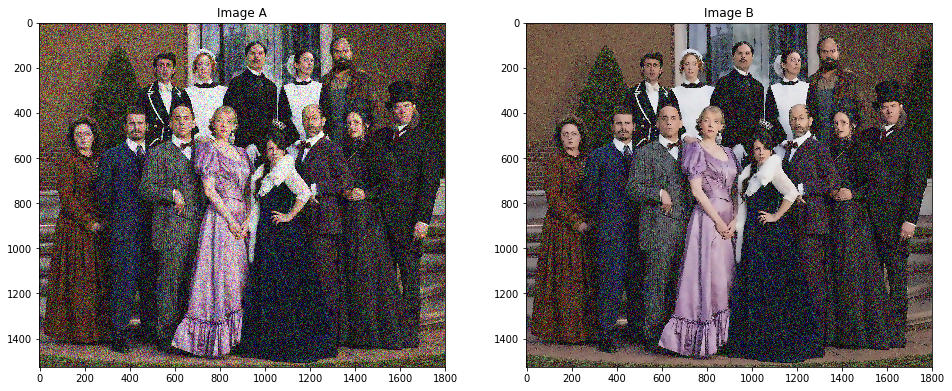

In [10]:
image_with_noise = noisy_image(image_family)
image_denoise = cv2.fastNlMeansDenoisingColored(image_with_noise, None, 15, 15)
plot_two_image(image_with_noise, image_denoise)

### 2.1 Face and Eye Detection

In [11]:
def face_detector(image, face_s=1.2, face_n=5): 
    # color info not helpful to detect faces
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_with_detections = np.copy(image)
    
    faces = face_cascade.detectMultiScale(image_gray, face_s, face_n)
    face_color = (255,0,0)
    # print('Number of faces detected:', len(faces))
    for (x, y, w, h) in faces: 
        cv2.rectangle(image_with_detections, (x, y), (x + w, y + h), face_color, 3)
    
    return image_with_detections

Each detected face by the Haar Cascade classifier is a 1D array with four entries that specifies the bounding box of the detected face.  The first two specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array specify the width and height of the box. 

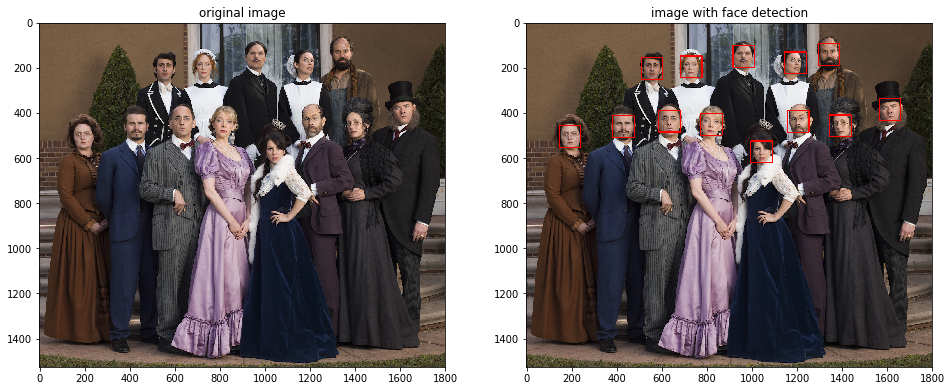

In [12]:
plot_two_image(image_family, face_detector(image_family, face_s=2), 'original image', 'image with face detection')

In next cell we briefly explore OpenCV's noise-removal functionality to see how we can clean up a noisy image, which we then feed into our trained face detector.  
Likely but not guaranteed, we'll see an improvement of 1 or 2 more face(s) being correctly identified after denoising. 

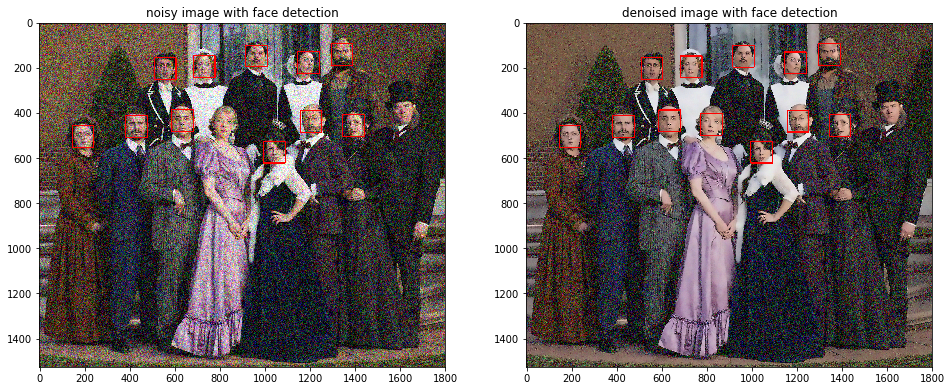

In [14]:
plot_two_image(face_detector(image_with_noise, face_s=2, face_n=5), 
               face_detector(image_denoise, face_s=2, face_n=5), 
               'noisy image with face detection', 'denoised image with face detection')

In [15]:
def face_eye_detector(image, face_s=1.2, face_n=5, eye_s=1.1, eye_n=5): 
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_with_detections = np.copy(image)
    
    faces = face_cascade.detectMultiScale(image_gray, face_s, face_n)
    face_color = (255,0,0)
    for index, (x_face, y_face, w_face, h_face) in enumerate(faces): 
        cv2.rectangle(image_with_detections, (x_face, y_face), (x_face + w_face, y_face + h_face), face_color, 3)
        image_gray_face = image_gray[y_face : y_face + h_face, x_face : x_face + w_face]
        
        # detect eyes within the face rectangle to minimize error
        eyes = eye_cascade.detectMultiScale(image_gray_face, eye_s, eye_n)
        # change color when abnormal - NOT 2 eyes on one face
        eye_color = (0,255,0) if len(eyes) == 2 else (0,0,255)
        # print('{} eyes detected in face #{}'.format(len(eyes), index + 1))
        for (x, y, w, h) in eyes: 
            x_eye = x + x_face
            y_eye = y + y_face
            cv2.rectangle(image_with_detections, (x_eye, y_eye), (x_eye + w, y_eye + h), eye_color, 2)
            
    return image_with_detections

To learn more about the parameters of the ```detectMultiScale``` function see [this post](https://stackoverflow.com/questions/20801015/recommended-values-for-opencv-detectmultiscale-parameters).

Notice that even though the image is a black and white image, we have read it in as a color image and so it will still need to be converted to grayscale in order to perform the most accurate detection.

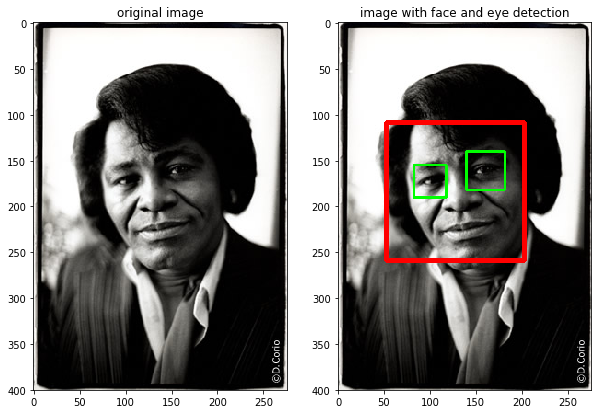

In [16]:
plot_two_image(image_james, face_eye_detector(image_james), 'original image', 'image with face and eye detection', size=(10,10))

### 2.2 Edge Detection

In [17]:
def canny_edge_detector(image, blur=True, threshold=[100,200]): 
    # color info not helpful to detect edges
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # blur the image so that only major edges are detected
    if blur: 
        image_gray = blur_image(image_gray)
    # detect and amplify edges
    image_edges = cv2.Canny(image_gray, threshold[0], threshold[1])
    image_edges = cv2.dilate(image_edges, None)
    return image_edges

Edge detection is a **convolution** performed on the image itself, and you can read about Canny edge detection on [this OpenCV documentation page](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html).

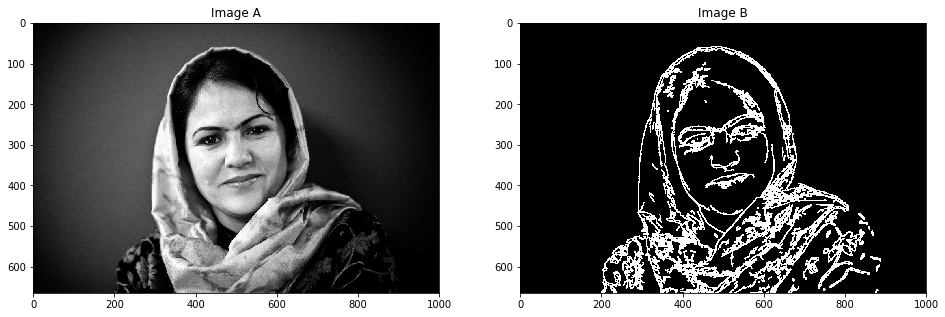

In [18]:
plot_two_image(image_fawzia, canny_edge_detector(image_fawzia, blur=False), grayB=True)

If the image is blurred first to remove these local structures, only the important boudnary details will remain in the edge-detected image.

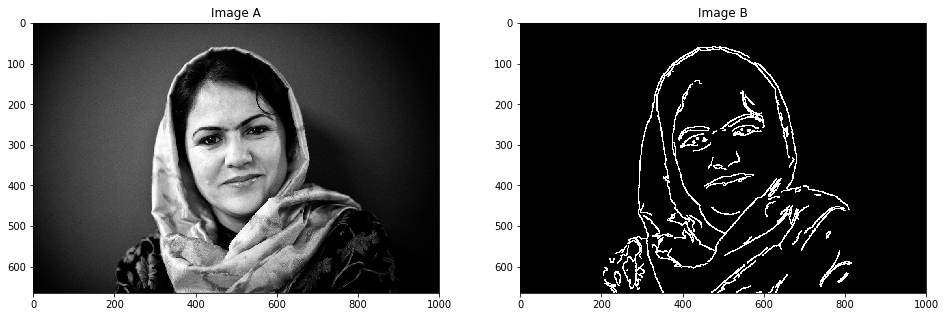

In [19]:
plot_two_image(image_fawzia, canny_edge_detector(image_fawzia), grayB=True)

### 2.3 Hide Individual Identity
Use face detection and image blurring in tandem to hide the identity of people in images. 

This is useful for projects like [Google's StreetView maps](https://www.google.com/streetview/) - an enormous collection of mapping images taken from a fleet of Google vehicles.  Because it would be impossible for Google to get the permission of every single person accidentally captured in one of these images they blur out everyone's faces, the detected images must automatically blur the identity of detected people.

In [20]:
def face_blur_detector(image, face_s=1.2, face_n=5): 
    image_blur = np.copy(image)
    # use a much larger width parameter to completely obscure identity
    avg_image = blur_image(image, width=50)
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    faces = face_cascade.detectMultiScale(image_gray, face_s, face_n)
    margin = 0.1
    for x, y, w, h in faces: 
        # additional margin to increase blurring coverage
        y_low = int(round(y - margin * h))
        y_high = int(round(y + (margin + 1) * h))
        x_low = int(round(x - margin * w))
        x_high = int(round(x + (margin + 1) * w))
        image_blur[y_low : y_high, x_low : x_high] = avg_image[y_low : y_high, x_low : x_high]
    
    return image_blur

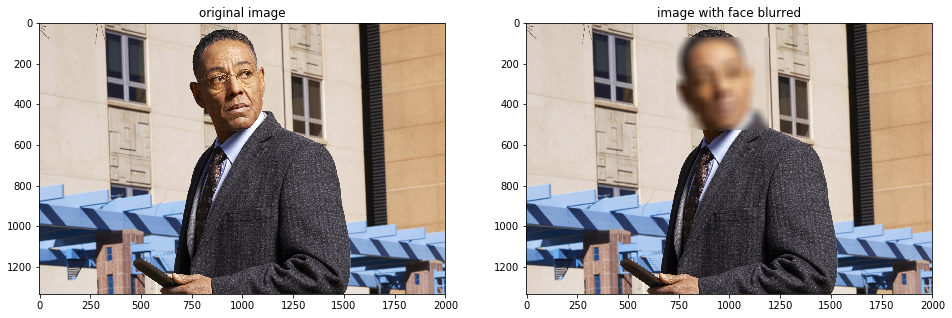

In [21]:
plot_two_image(image_gus, face_blur_detector(image_gus), 'original image', 'image with face blurred')

### 2.4 Facial Keypoints Detection
We will be using [this dataset from Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data) to train a *convolutional neural network* to recognize a set of 15 facial keypoints (a set of 15 corresponding $(x, y)$ coordinates) on a single face. This data has been downloaded and placed in the `data` directory.  The training dataset contains several thousand $96 \times 96$ grayscale images of cropped human faces, along with each face's 15 corresponding facial keypoints (also called landmarks) that have been placed by hand, and recorded in $(x, y)$ coordinates.  This wonderful resource also has a substantial testing set, which we will use in tinkering with our convolutional network.

In [22]:
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


For each training image, there are two landmarks per eyebrow (**four** total), three per eye (**six** total), **four** for the mouth, and **one** for the tip of the nose. 

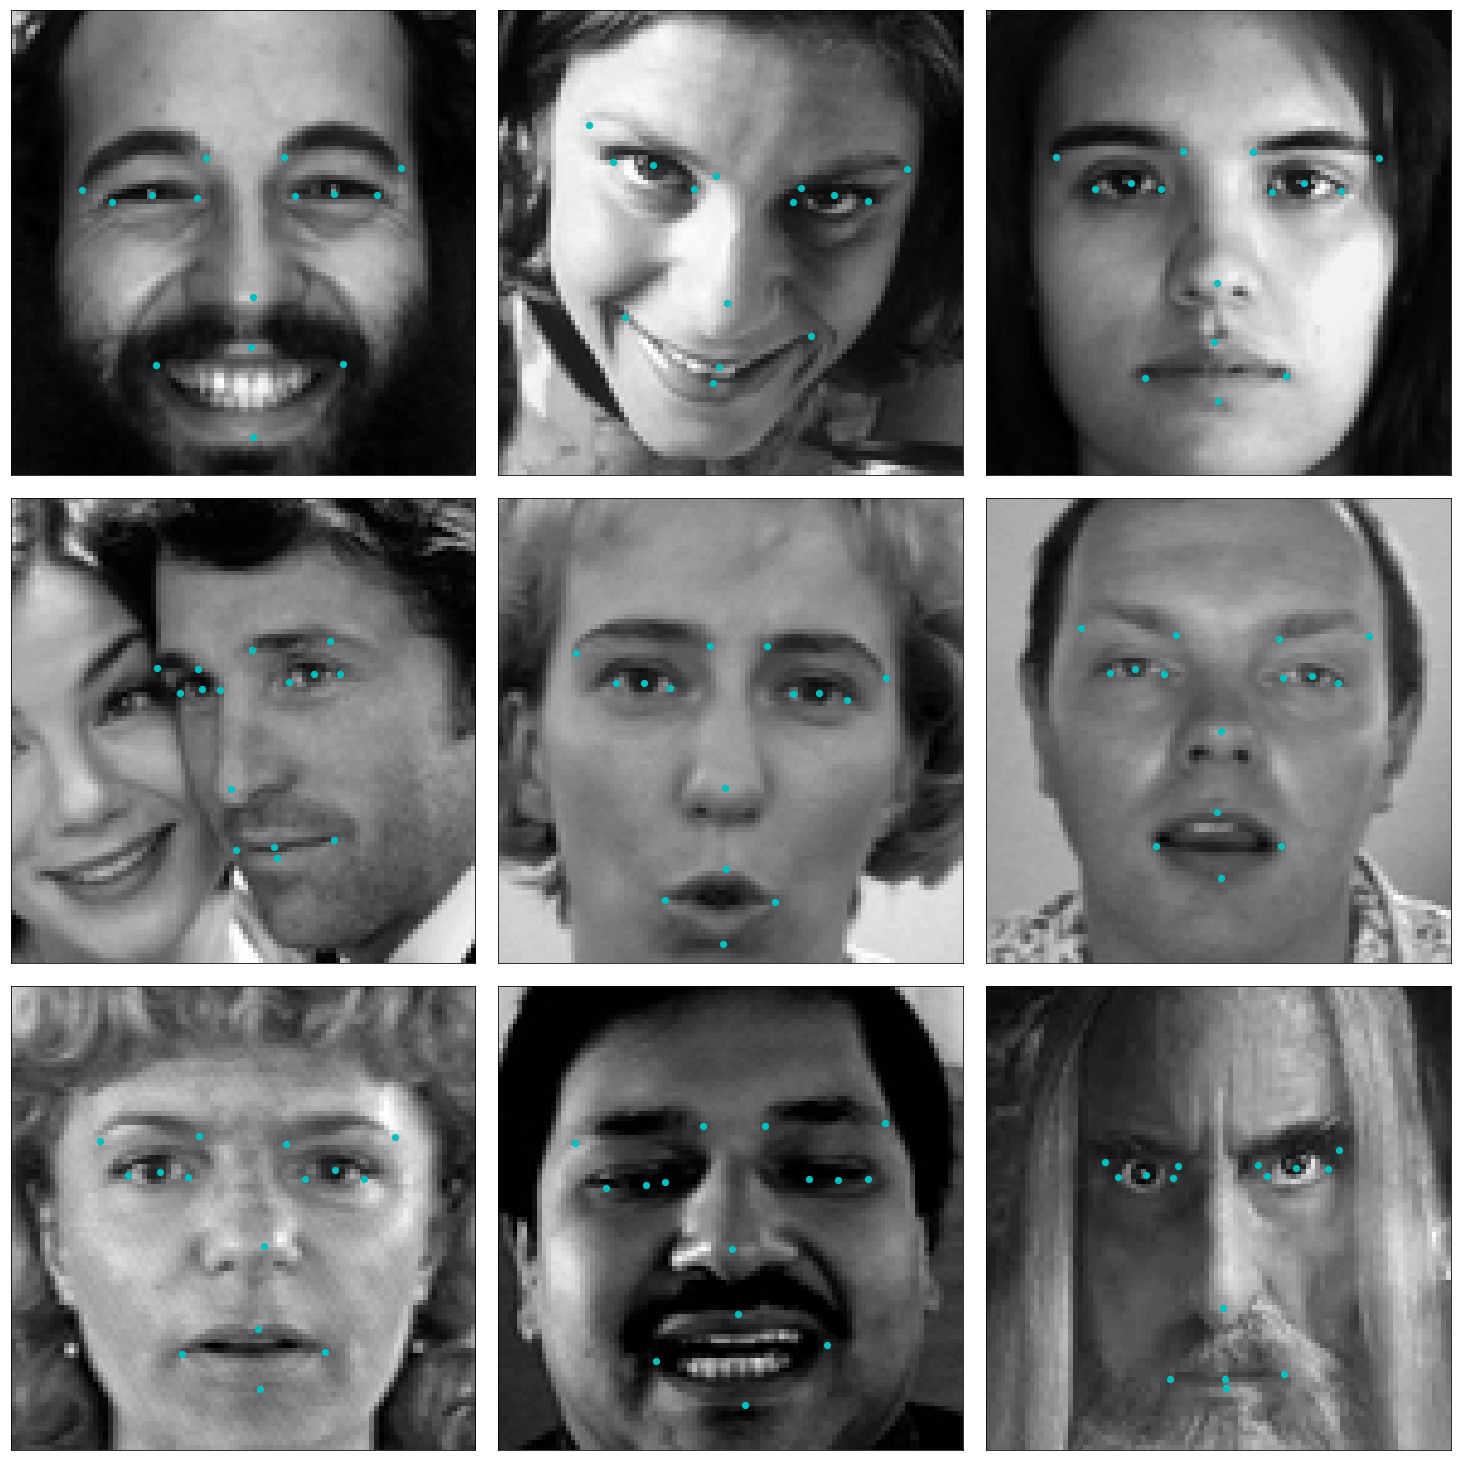

In [23]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

The nueral network will accept a $96 \times 96$ grayscale image as input, and output a vector with 30 entries, corresponding to the predicted (horizontal and vertical) locations of 15 facial keypoints.  Some reference architectures are in [this blog](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/)

In [24]:
model = Sequential()

model.add(Convolution2D(filters=16, kernel_size=4, padding='same', activation='relu', input_shape=(96, 96, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Convolution2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30, activation='tanh'))

# my own short-hand summary
# conv2d: 16-64-128; dense: 300-100
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        272       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       32896     
__________

In [26]:
custom_opt = RMSprop(lr=0.0005)
model.compile(loss='mean_squared_error', optimizer=custom_opt, metrics=['mae'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, epochs=75, validation_split=0.2, callbacks=[checkpointer], verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/75
Epoch 00000: val_loss improved from inf to 0.02086, saving model to model.weights.best.hdf5
42s - loss: 0.0398 - mean_absolute_error: 0.1482 - val_loss: 0.0209 - val_mean_absolute_error: 0.1167
Epoch 2/75
Epoch 00001: val_loss improved from 0.02086 to 0.01430, saving model to model.weights.best.hdf5
38s - loss: 0.0149 - mean_absolute_error: 0.0959 - val_loss: 0.0143 - val_mean_absolute_error: 0.0968
Epoch 3/75
Epoch 00002: val_loss did not improve
39s - loss: 0.0103 - mean_absolute_error: 0.0790 - val_loss: 0.0184 - val_mean_absolute_error: 0.1111
Epoch 4/75
Epoch 00003: val_loss improved from 0.01430 to 0.00449, saving model to model.weights.best.hdf5
39s - loss: 0.0082 - mean_absolute_error: 0.0704 - val_loss: 0.0045 - val_mean_absolute_error: 0.0492
Epoch 5/75
Epoch 00004: val_loss improved from 0.00449 to 0.00443, saving model to model.weights.best.hdf5
42s - loss: 0.0070 - mean_absolute_error: 0.0643 - val_loss: 0.0044 - va

Epoch 00045: val_loss improved from 0.00095 to 0.00093, saving model to model.weights.best.hdf5
53s - loss: 7.9382e-04 - mean_absolute_error: 0.0213 - val_loss: 9.3312e-04 - val_mean_absolute_error: 0.0211
Epoch 47/75
Epoch 00046: val_loss did not improve
50s - loss: 7.6640e-04 - mean_absolute_error: 0.0209 - val_loss: 0.0010 - val_mean_absolute_error: 0.0222
Epoch 48/75
Epoch 00047: val_loss did not improve
45s - loss: 7.5676e-04 - mean_absolute_error: 0.0209 - val_loss: 9.6758e-04 - val_mean_absolute_error: 0.0213
Epoch 49/75
Epoch 00048: val_loss did not improve
42s - loss: 7.4414e-04 - mean_absolute_error: 0.0207 - val_loss: 9.4538e-04 - val_mean_absolute_error: 0.0211
Epoch 50/75
Epoch 00049: val_loss improved from 0.00093 to 0.00091, saving model to model.weights.best.hdf5
42s - loss: 7.5228e-04 - mean_absolute_error: 0.0207 - val_loss: 9.1439e-04 - val_mean_absolute_error: 0.0208
Epoch 51/75
Epoch 00050: val_loss improved from 0.00091 to 0.00089, saving model to model.weights.be

Run Experiments to tune global parameters

1. Architect = conv2d: 16-32-64; dense: 300; dropout: 0.2.  Training = optimizer: {```Adagrad```, ```Adam```, **```RMSprop```**, ```SGD```}; epochs: 50; learn_rate: 0.001
2. Architect = conv2d: {16-32-64, **16-64-128**, 32-64-128}; dense: 300; dropout: 0.2.  Training = Optimizer: ```RMSprop```; epochs: 50; learn_rate: 0.001
3. Architect = conv2d: 16-64-128; dense: {300, 400, **300-100**}; dropout: 0.2.  Training = Oprimizer: ```RMSprop```; epochs: 50; learn_rate: 0.001
4. Architect = conv2d: 16-64-128; dense: 300-100; dropout: {**0.1**, 0.2, 0.3}.  Training = Oprimizer: ```RMSprop```; epochs: 50; learn_rate: 0.001
5. Architect = conv2d: 16-64-128; dense: 300-100; dropout: 0.1.  Training = Oprimizer: ```RMSprop```; epochs: 50; learn_rate: {0.001, 0.00075, **0.0005**}

{competing choices}, 
**winning choices**

In [27]:
# After many experiments, save final model
model.save('my_model.h5')

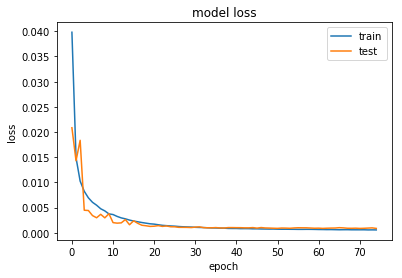

In [28]:
# Visualize the training and validation loss of current neural network
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

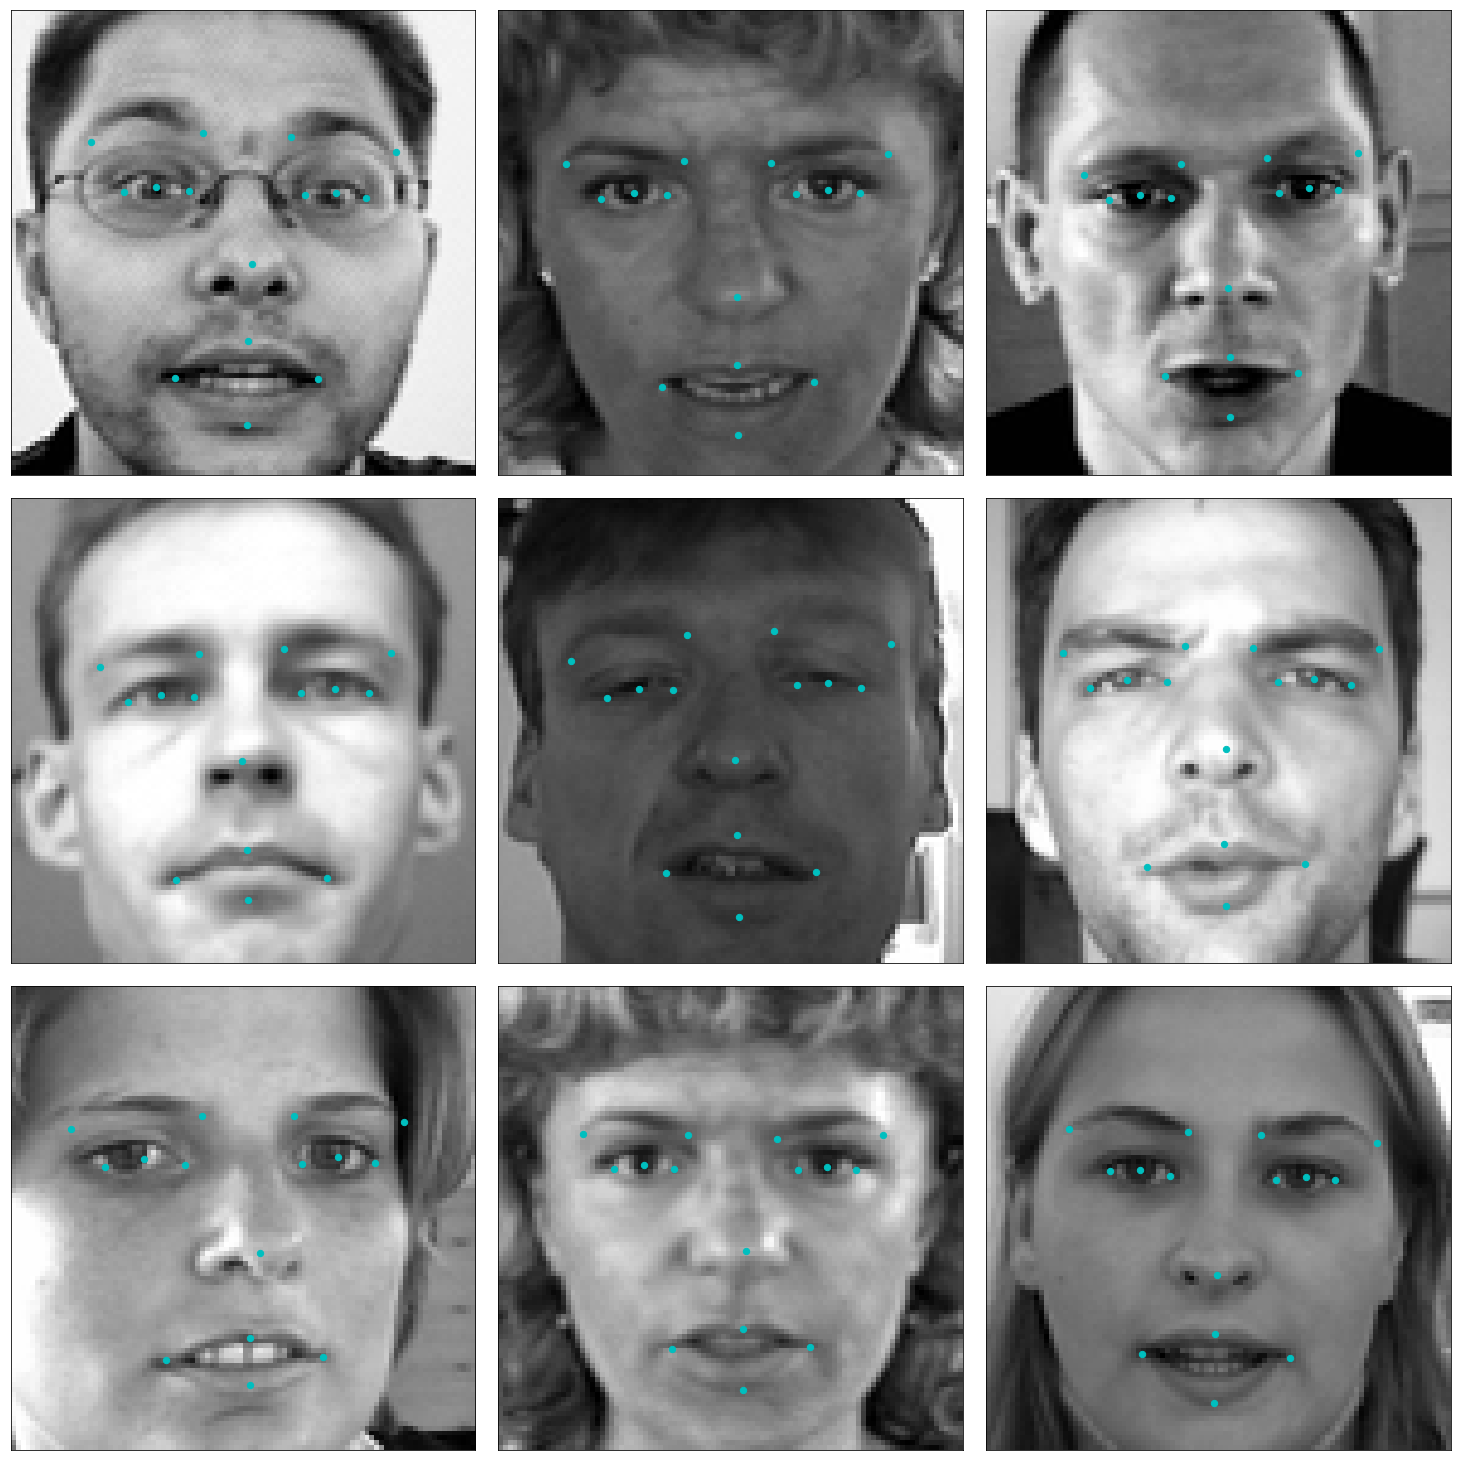

In [29]:
# Visualize a subset of predictions on test set
y_test = model.predict(X_test)
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_test[i], y_test[i], ax)

A complete pipeline
1. Accept a color image.
2. Convert the image to grayscale.
3. Detect and crop the face contained in the image.
4. Locate the facial keypoints in the cropped image.
5. Overlay the facial keypoints in the original (color, uncropped) image.

In [30]:
# Neural Network trained by this notebook previously
face_convnet = load_model('my_model.h5')

In [31]:
def face_keypoint_detector(image, face_s=1.2, face_n=6): 
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_with_detections = np.copy(image)
    
    face_color, point_color = (255,0,0), (0,255,0)
    faces = face_cascade.detectMultiScale(image_gray, face_s, face_n)
    for x_face, y_face, w_face, h_face in faces: 
        cv2.rectangle(image_with_detections, (x_face, y_face), (x_face + w_face, y_face + h_face), face_color, 2)
        # Only face area are fed into trained neural network after resizing
        face_gray = image_gray[y_face : y_face + h_face, x_face : x_face + w_face]
        face_detect = cv2.resize(face_gray, (96, 96)) / 255.0
        # Reshape predictions to a long list
        face_keypoints = np.squeeze(face_convnet.predict(np.expand_dims(np.expand_dims(face_detect, axis=-1), axis=0)))
        for x, y in zip(face_keypoints[0::2], face_keypoints[1::2]):
            # Undo the normalization
            x_point = (x * 48 + 48) * face_gray.shape[0] / 96 + x_face
            y_point = (y * 48 + 48) * face_gray.shape[1] / 96 + y_face
            cv2.circle(image_with_detections, (int(x_point), int(y_point)), 3, point_color, -1)
    
    return image_with_detections

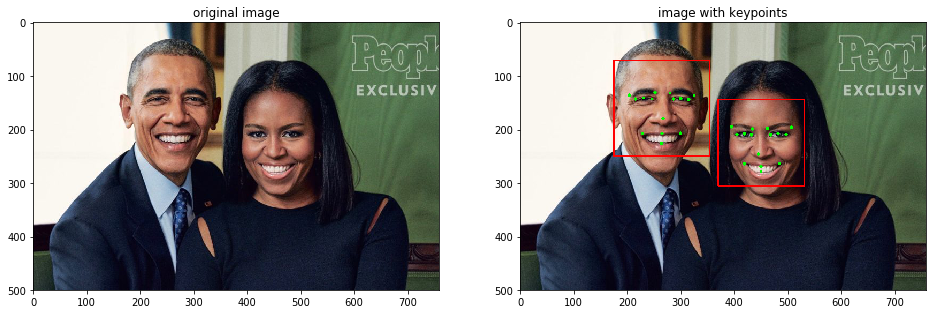

In [32]:
plot_two_image(image_obama, face_keypoint_detector(image_obama), 'original image', 'image with keypoints')

### 2.5 Add Filters to Faces

In [33]:
def face_keypoint_filter_old(image, face_s=1.2, face_n=5): 
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_with_detections = np.copy(image)
    
    faces = face_cascade.detectMultiScale(image_gray, face_s, face_n)
    for x_face, y_face, w_face, h_face in faces: 
        face_gray = image_gray[y_face : y_face + h_face, x_face : x_face + w_face]
        face_detect = cv2.resize(face_gray, (96, 96)) / 255.0
        # Reshape predictions to a long list
        face_keypoints = np.squeeze(face_convnet.predict(np.expand_dims(np.expand_dims(face_detect, axis=-1), axis=0)))
        # Separate x and y coordinates and undo normalization
        x_keypoints = (face_keypoints[0::2] * 48 + 48) * face_gray.shape[0] / 96 + x_face
        y_keypoints = (face_keypoints[1::2] * 48 + 48) * face_gray.shape[1] / 96 + y_face
        
        x_left_outer_eyebrow, y_left_outer_eyebrow = x_keypoints[9], y_keypoints[9]
        x_right_outer_eyebrow, y_right_outer_eyebrow = x_keypoints[7], y_keypoints[7]
        x_tip_nose, y_tip_nose = x_keypoints[10], y_keypoints[10]
        y_left_inner_eye = y_keypoints[4]
        y_right_inner_eye = y_keypoints[2]
        
        # simply resize sunglass image to fit onto certain keypoints
        w_glass = int((x_right_outer_eyebrow - x_left_outer_eyebrow + w_face) * 0.5)
        x_glass = int(x_tip_nose - w_glass * 0.5)
        y_glass = int((y_left_outer_eyebrow + y_right_outer_eyebrow) * 0.5)
        h_glass = int((y_tip_nose - y_glass) * 0.75)
        sunglass_fit = cv2.resize(sunglasses, (w_glass, h_glass))
        for x_point in range(w_glass): 
            for y_point in range(h_glass): 
                if sunglass_fit[y_point, x_point, 3] == 0: continue
                image_with_detections[y_glass + y_point, x_glass + x_point] = sunglass_fit[y_point, x_point, 0:3]
    
    return image_with_detections

This method is my **first attempt**, no problem with the given test image, but **not a good one when the face(s) are not upstraight**

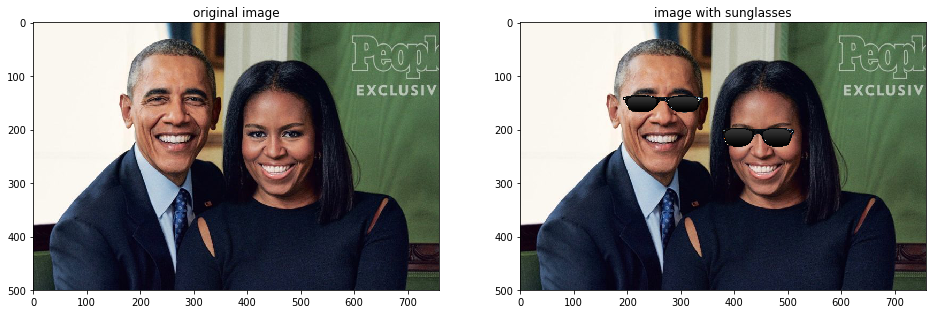

In [34]:
plot_two_image(image_obama, face_keypoint_filter_old(image_obama), 'original image', 'image with sunglasses')

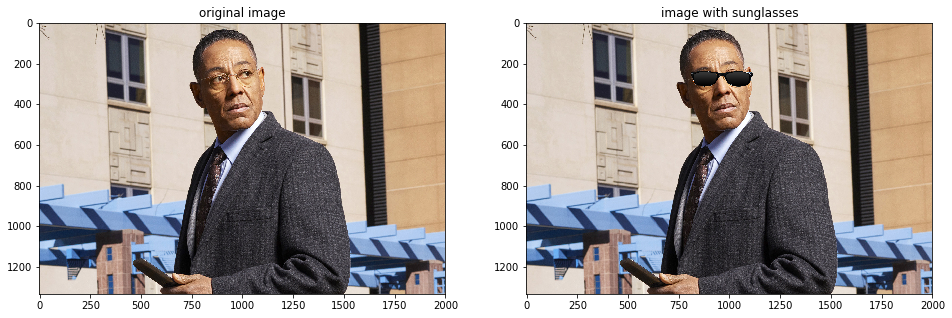

In [35]:
plot_two_image(image_gus, face_keypoint_filter_old(image_gus), 'original image', 'image with sunglasses')

In [36]:
def face_keypoint_filter(image, face_s=1.2, face_n=5): 
    rows, cols, channel = image.shape
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_with_detections = np.copy(image)
    
    faces = face_cascade.detectMultiScale(image_gray, face_s, face_n)
    for x_face, y_face, w_face, h_face in faces: 
        face_gray = image_gray[y_face : y_face + h_face, x_face : x_face + w_face]
        face_detect = cv2.resize(face_gray, (96, 96)) / 255.0
        # Reshape predictions to a long list
        face_keypoints = np.squeeze(face_convnet.predict(np.expand_dims(np.expand_dims(face_detect, axis=-1), axis=0)))
        # Separate x and y coordinates and undo normalization
        x_keypoints = (face_keypoints[0::2] * 48 + 48) * face_gray.shape[0] / 96 + x_face
        y_keypoints = (face_keypoints[1::2] * 48 + 48) * face_gray.shape[1] / 96 + y_face
        
        # Locate 3 points for each face as sunglass filter position
        x_left_outer_eyebrow, y_left_outer_eyebrow = x_keypoints[9], y_keypoints[9]
        x_right_outer_eyebrow, y_right_outer_eyebrow = x_keypoints[7], y_keypoints[7]
        x_tip_nose, y_tip_nose = x_keypoints[10], y_keypoints[10]
        x_left_inner_eye, y_left_inner_eye = x_keypoints[4], y_keypoints[4]
        x_right_inner_eye, y_right_inner_eye = x_keypoints[2], y_keypoints[2]
        x_middle = ((x_left_inner_eye + x_right_inner_eye) / 2 + x_tip_nose) / 2
        y_middle = ((y_left_inner_eye + y_right_inner_eye) / 2 + y_tip_nose) / 2
        
        # warp sunglass image to match the above keypoints
        point_sunglass = np.float32([[300, 100], [2800, 100], [1500, 900]])
        point_face = np.float32([[x_left_outer_eyebrow, y_left_outer_eyebrow], 
                                 [x_right_outer_eyebrow, y_right_outer_eyebrow], [x_middle, y_middle]])
        warpM = cv2.getAffineTransform(point_sunglass, point_face)
        image_sunglass = cv2.warpAffine(sunglasses, warpM, (cols, rows))
        for x_point in range(cols): 
            for y_point in range(rows): 
                if image_sunglass[y_point, x_point, 3] == 0: continue
                image_with_detections[y_point, x_point] = image_sunglass[y_point, x_point, 0:3]
        
    return image_with_detections

Above is the **improved version**, which **works well even when the face(s) are tilted**

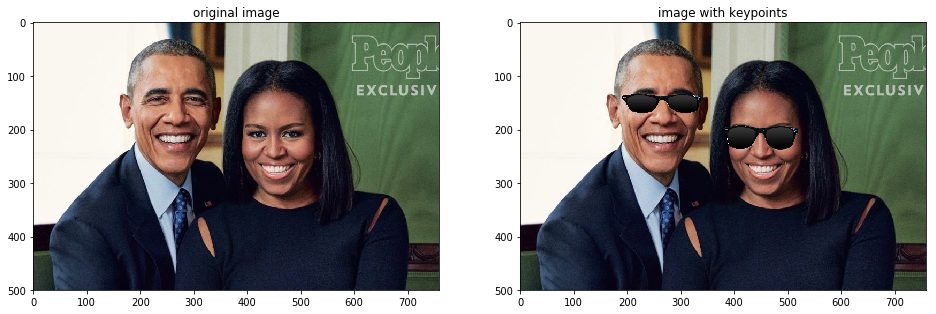

In [37]:
plot_two_image(image_obama, face_keypoint_filter(image_obama), 'original image', 'image with keypoints')

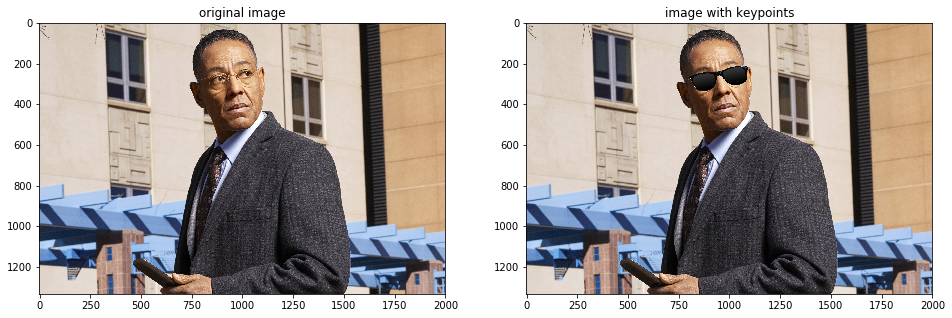

In [38]:
plot_two_image(image_gus, face_keypoint_filter(image_gus), 'original image', 'image with keypoints')

### 3.1 Run Functions with Camera

In [39]:
def laptop_camera_go(face_function): 
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # Keep the video stream open
    while rval:
        # Plot the image from camera after processed by any function (face detection, blurring, etc.) defined previously
        cv2.imshow("face detection activated", face_function(frame))
        
        # Exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key < 255: # Exit by pressing any key
            # Destroy windows 
            cv2.destroyAllWindows()
            
            # Make sure window closes on OSx
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()

In [40]:
laptop_camera_go(face_eye_detector)

**Note:** Mac users may find that activating this function kills the kernel of their notebook every once in a while.  If this happens to you, just restart your notebook's kernel, activate cell(s) containing any crucial import statements, and you'll be good to go!

In [41]:
laptop_camera_go(face_blur_detector)

In [42]:
laptop_camera_go(face_keypoint_detector)

In [43]:
laptop_camera_go(face_keypoint_filter)